In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
from utils.common_settings import *
from data_loader import data_loader_ml
from data_loader.data_loader_ml import DatasetDict, DataRepo

In [ ]:
import matplotlib as mpl
from matplotlib import rcParams
mpl.rcParams.update(mpl.rcParamsDefault)

# plt.style.use(['science', "grid"])

plt.rcParams["font.family"] = "Times New Roman"

OSError: 'science' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

# Data Loading

In [4]:
ds_keys = ["INS-W_1","INS-W_2","INS-W_3","INS-W_4"]
colors = [ "#d7191c", "#fdae61", "#1a9641", "#2b83ba"]

In [5]:
dataset_dict_raw = data_loader_ml.data_loader_raw(
    ds_keys_list = ds_keys,
    verbose = False
)

In [6]:
dataset_dict = data_loader_ml.data_loader(ds_keys_dict={
    "dep_weekly": ds_keys}, flag_more_feat_types=True, verbose = False)

In [7]:
dataset_dict_weekly = dataset_dict["dep_weekly"]

## Feature Definition

In [8]:
df_tmp = dataset_dict_raw[ds_keys[0]]
feature_columns_full = sorted(list(set(df_tmp.columns).difference(set(["pid", "date", "device_type", "dep"])))) # remove non-feature columns
feature_columns_numeric = [f for f in feature_columns_full if df_tmp[f].dtype.kind in "bifc"]
feature_columns_allday = [f for f in feature_columns_numeric if f.endswith(":allday")]

In [9]:
feature_columns_filtered = []
for f in feature_columns_allday:
    na_rate = [ dataset_dict_raw[ds_key][f].isna().sum() / dataset_dict_raw[ds_key].shape[0] for ds_key in ds_keys]
    if max(na_rate) < 0.9:
        feature_columns_filtered.append(f)

In [10]:
timerange_list = ["allday", "morning", "afternoon", "evening", "night", "14dhist"]
feature_columns_filtered_timeranges_dict = {}
for timerange in timerange_list:
    feature_columns_filtered_timeranges_dict[timerange] = deepcopy([f.replace(f":allday", f":{timerange}") for f in feature_columns_filtered])
feature_columns_filtered_timeranges = np.concatenate(list(feature_columns_filtered_timeranges_dict.values()))

In [11]:
feature_columns_nonorm = [f for f in feature_columns_filtered if f.endswith(":allday") and not f.endswith("_norm:allday")]
feature_columns_norm = [f for f in feature_columns_filtered if f.endswith("_norm:allday")]

In [12]:
dataset_dict_raw_filtered = {}
dataset_dict_raw_filtered_withna = {}
for ds_key in ds_keys:
    df_tmp = dataset_dict_raw[ds_key][feature_columns_nonorm]
    df_tmp_narate = df_tmp.apply(lambda row : pd.isna(row).sum() / df_tmp.shape[1], axis = 1)
    dataset_dict_raw_filtered_withna[ds_key] = deepcopy(dataset_dict_raw[ds_key][["pid", "date"] + feature_columns_numeric][df_tmp_narate < 0.8])
    dataset_dict_raw_filtered_withna[ds_key]["date"] = pd.to_datetime(dataset_dict_raw_filtered_withna[ds_key]["date"])
    dataset_dict_raw_filtered[ds_key] = deepcopy(dataset_dict_raw_filtered_withna[ds_key].fillna(dataset_dict_raw_filtered_withna[ds_key].median()))

### NA Analysis

In [13]:
dataset_dict_raw_filtered_tmp = {}
for ds_key in ds_keys:
    df_tmp = dataset_dict_raw[ds_key][feature_columns_nonorm]
    df_tmp_narate = df_tmp.apply(lambda row : pd.isna(row).sum() / df_tmp.shape[1], axis = 1)
    dataset_dict_raw_filtered_tmp[ds_key] = dataset_dict_raw[ds_key][["pid", "date"] + feature_columns_numeric][df_tmp_narate < 0.8]

narate_pivot_list = []

for ds_key in ["INS-W_1", "INS-W_2", "INS-W_3", "INS-W_4"]:
    f = "f_loc:phone_locations_doryab_avgspeed:allday"
    df_pivot = dataset_dict_raw_filtered_tmp[ds_key].pivot(index= "pid", columns="date", values=f)
    narate_pivot = df_pivot.isna().sum().sum() / (df_pivot.shape[0] * df_pivot.shape[1])
    narate_pivot_list.append(narate_pivot)
print(np.mean(narate_pivot_list), np.std(narate_pivot_list))

0.14468115189163303 0.03962928809741215


## Data Amount Analysis

In [14]:
count_dict = {}
for ii, ds_key in enumerate(ds_keys):
    count_dict[ds_key] = dataset_dict_raw_filtered[ds_key].groupby("pid").count().iloc[:,0]

In [15]:
label_count_dict = {}
for ii, ds_key in enumerate(ds_keys):
    label_count_dict[ds_key] = dataset_dict_weekly[ds_key].datapoints.groupby("pid").count().values[:,0]
label_count = np.concatenate([label_count_dict[k] for k in ds_keys])
print(np.mean(label_count), np.std(label_count))

11.602857142857143 2.594938558511353


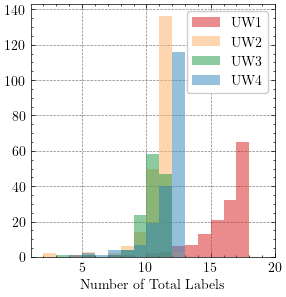

In [40]:
fig, ax = plt.subplots(figsize = (3,3))

for ii, ds_key in enumerate(ds_keys):
    ax.hist(dataset_dict_weekly[ds_key].datapoints.groupby("pid").count().values[:,0], 
            bins = np.linspace(1,20,20),
            color = colors[ii], alpha = 0.5)
    
ax.legend(["UW1","UW2","UW3","UW4"], ncol = 1, loc=0)

plt.tight_layout()
ax.set_xlabel("Number of Total Labels")
ax.set_xlim((1,20))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
plt.savefig("../plots/hist_labelcounts_neurips.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

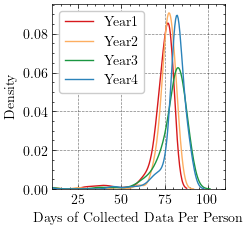

In [41]:
fig, ax = plt.subplots(figsize = (2.5,2.5))

for ii, ds_key in enumerate(ds_keys):
    sns.distplot(dataset_dict_raw_filtered[ds_key].groupby("pid").count().values.max(axis=1), hist=False, ax = ax, color = colors[ii])
    
ax.legend(["Year1","Year2","Year3","Year4"], ncol = 1, loc=0,)# bbox_to_anchor=(0.5, -0.07, 0.0, 0.5))

ax.set_xlabel("Days of Collected Data Per Person")
ax.set_xlim((10,110))
plt.tight_layout()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
plt.savefig("../plots/hist_datacounts_neurips.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

# Feature Analysis

## Feature Value distribution

In [23]:
example_features = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": "[Location] (2wks)\nAverage Number of Frequent Locations",
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": "[PhoneUsage] (whole day)\nTotal Duration of Unlock Episodes",
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": "[Activity] (whole day)\nNumber of Steps",
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": "[Sleep] (2wks)\nAverage Duration Asleep",
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": "[Call] (2wks)\n Average duration of Daily Outgoing Call",
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": "[Bluetooth] (2wks)\n Number of Unique Devices"
    
}

xlabels_dict = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": "Count",
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": "Hours",
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": "Count / Thousand",
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": "Hours",
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": "Mins",
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": "Count",
    
}

scale_dict = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": 14,
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": 60*14,
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": 1000,
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": 60,
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": 60,
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": 1,
}

x_range_dict = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": [0,3.7],
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": [0,10],
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": [0,25],
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": [4,10],
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": [0,15],
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": [0,8],
}

y_lim_dict = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": [0,2.4],
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": [0,0.32],
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": [0,0.215],
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": [0,0.61],
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": [0,0.4],
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": [0,1.01],
}

smooth_dict = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": 1,
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": 1.5,
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": 1,
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": 1.2,
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": 1,
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": 1,
}

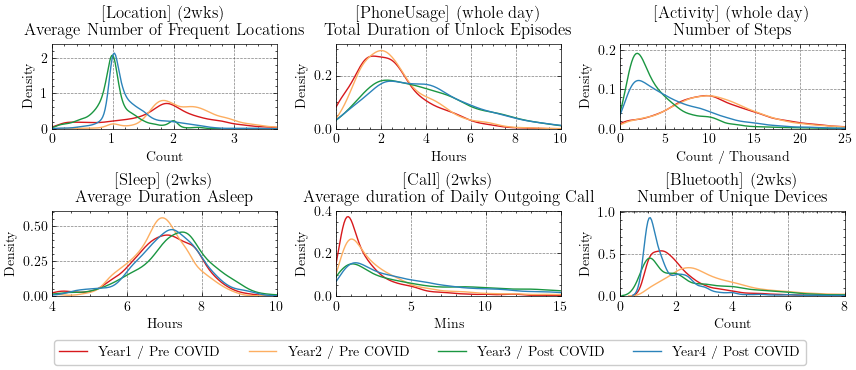

In [34]:
fig, axes = plt.subplots(figsize = (8.5,3.4), ncols = 3, nrows = 2)

for idx, feature in enumerate(example_features):
    ax = axes[idx//3][idx%3]
    feature_dict = {ds_key: dataset_dict_raw_filtered_withna[ds_key][feature].values / scale_dict[feature] for ds_key in ds_keys}
    
    for ii, ds_key in enumerate(ds_keys):
        if feature not in x_range_dict:
            sns.distplot(feature_dict[ds_key],  hist=False, ax = ax, color = colors[ii])
        else:
            sns.distplot([x for x in feature_dict[ds_key] if (x_range_dict[feature][0] * 0.9 < x and x < x_range_dict[feature][1] * 1.1)],
                         kde_kws={"bw_adjust":smooth_dict[feature]},
                         hist=False, ax = ax, color = colors[ii])
    ax.set_title(example_features[feature],fontsize=12)
    ax.set_xlabel(xlabels_dict[feature])
    ax.set_xlim(x_range_dict[feature])
    ax.set_ylim(y_lim_dict[feature])
    
fig.legend(["Year1 / Pre COVID","Year2 / Pre COVID","Year3 / Post COVID","Year4 / Post COVID"], ncol = 4, loc=8, bbox_to_anchor=(0.5, -0.1, 0.0, 0.5))

plt.tight_layout(pad=0.5)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
plt.savefig("../plots/singlefeat_pdf_examples_neurips.pdf", dpi = 300, bbox_inches = "tight")
plt.show()


### Feature Temporal Example

In [98]:
quarter_start_date = {
    1: "2018-03-26", 2: "2019-04-01",
    3: "2020-03-30", 4: "2021-03-29"}
date_range = {}
for phase in range(1,5):
    start_date = pd.to_datetime(quarter_start_date[phase])
    end_date = start_date + timedelta(days = 69)
    date_range[phase] = {"start": start_date, "end": end_date}

In [99]:
nanosecond_xticks = np.array([0, 60480, 120960, 181440,
                     241920, 302400, 362880,
                     423360, 483840, 544320]) * 1e10
nanosecond_xticks_weekend = np.array([0, 60480, 120960, 181440,
                     241920, 302400, 362880,
                     423360, 483840, 544320]) * 1e10 + 5 * 24 * 3600 * 1e9


In [103]:
scale_dict = {
"f_loc:phone_locations_barnett_disttravelled:allday": 1000,
"f_steps:fitbit_steps_intraday_rapids_sumsteps:allday":1000,
"f_slp:fitbit_sleep_summary_rapids_avgdurationinbedmain:allday": 60,
}

y_label_dict = {
"f_loc:phone_locations_barnett_disttravelled:allday": "Distance / km",
"f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": "Count / thousands",
"f_slp:fitbit_sleep_summary_rapids_avgdurationinbedmain:allday": "Duration / hrs",
}

y_lim_dict = {
"f_loc:phone_locations_barnett_disttravelled:allday": [-2,62],
"f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": [2.6,13],
"f_slp:fitbit_sleep_summary_rapids_avgdurationinbedmain:allday": [6.9,8.5]
}

title_dict = {
"f_loc:phone_locations_barnett_disttravelled:allday": "[Location] Travel Distance",
"f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": "[Activity] Step Count",
"f_slp:fitbit_sleep_summary_rapids_avgdurationinbedmain:allday": "[Sleep] Duration in Bed",
}

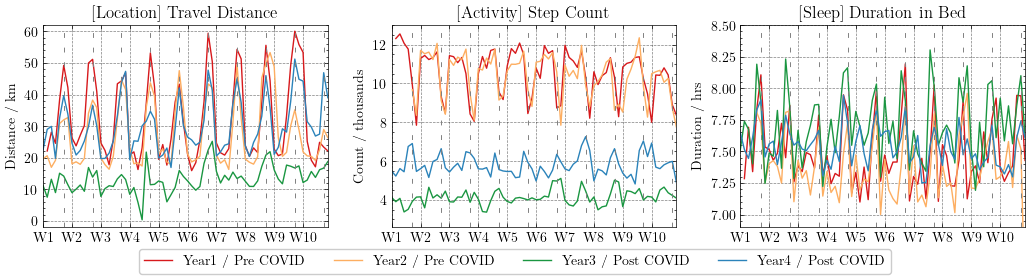

In [104]:
fig, axes = plt.subplots(figsize = (10.5,2.7), ncols=3)

df_plot_data = {}
for idx_feature, feature in enumerate(scale_dict):
    ax = axes[idx_feature]
    df_plot_data_feature = {}
    for i, ds_key in enumerate(ds_keys):
        ins, phase = ds_key.split("_")
        phase = int(phase)
        data_tmp = deepcopy(dataset_dict_raw_filtered_withna[ds_key][["date",feature]])
        low, high = np.nanpercentile(data_tmp[feature], q = [2.5, 97.5])
        data_tmp = data_tmp[(low < data_tmp[feature]) & (data_tmp[feature] < high)]
        data = data_tmp.groupby("date")[feature].mean() / scale_dict[feature]
        data_in_range = data.loc[data.index[(date_range[phase]["start"] <= data.index) & (data.index <= date_range[phase]["end"])]]
        data_in_range.index = data_in_range.index - date_range[phase]["start"]
        df_plot_data_feature[ds_key] = deepcopy(data_in_range)
        data_in_range.plot(ax = ax, color = colors[i], label = "Year" + str(phase))
    df_plot_data[feature] = pd.DataFrame(df_plot_data_feature)
    ax.set_xticks(nanosecond_xticks)
    ax.set_xticklabels(["W" + str(i) for i in range(1,11)])
    ax.set_xlabel("")
    ax.set_ylabel(y_label_dict[feature])
    ax.set_ylim(y_lim_dict[feature])
    ax.set_title(title_dict[feature])
    for x in nanosecond_xticks_weekend:
        ax.axvline(x, linewidth = 0.7, color = "gray", linestyle = (0, (5, 10)))
    ax.tick_params(axis='x', which='minor', bottom=False, top = False)
fig.legend(["Year1 / Pre COVID","Year2 / Pre COVID","Year3 / Post COVID","Year4 / Post COVID"], ncol = 4, loc=8, bbox_to_anchor=(0.5, -0.08, 0.0, 0.5))
plt.tight_layout()
plt.savefig("../plots/singlefeat_timeseries_examples_neurips.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

## Label Distribution

In [48]:
label_endterm_dict = {ds_key:[] for ds_key in ds_keys}
label_weekly_dict = {ds_key:[] for ds_key in ds_keys}
for ds_key in ds_keys:
    for idx, row in dataset_dict_weekly[ds_key].datapoints.iterrows():
        yraw = row["y_allraw"]
        if ("BDI2" in yraw and not pd.isna(yraw["BDI2"])):
            label_endterm_dict[ds_key].append(yraw["BDI2"])
        if ("phq4" in yraw and not pd.isna(yraw["phq4"])):
            label_weekly_dict[ds_key].append(yraw["phq4"])

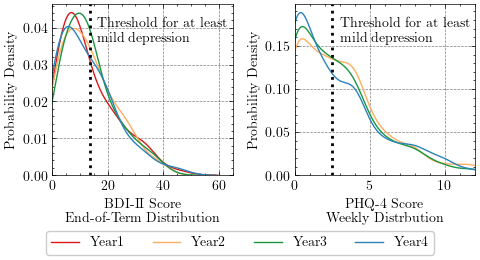

In [49]:
fig, axes = plt.subplots(figsize = (5,2.5), ncols = 2)

ax = axes[0]
for ii, ds_key in enumerate(ds_keys):
    sns.distplot(label_endterm_dict[ds_key], hist=False, bins = np.linspace(0,63,16), ax = ax, color = colors[ii], kde_kws={"bw_adjust": 1.2})
ax.set_xlabel("BDI-II Score\n End-of-Term Distribution")
ax.set_xlim((0,65))
fig.legend(["Year1","Year2","Year3","Year4"], ncol = 4, loc = 'lower center', bbox_to_anchor=(0.5, -0.09, 0.0, 0.5))
ax.axvline(x = 13.5, color = "black", linestyle = ":", linewidth = 2)
ax.text(x = 16, y = 0.78 * ax.get_ylim()[1], s = "Threshold for at least\n mild depression")
ax.set_ylabel("Probability Density")
    
ax = axes[1]
for ii, ds_key in enumerate(ds_keys):
    sns.distplot(label_weekly_dict[ds_key], hist=False, bins = np.linspace(0,12,13), ax = ax, color = colors[ii], kde_kws={"bw_adjust": 1.2})
ax.set_xlabel("PHQ-4 Score\n Weekly Distrbution")
ax.set_xlim((0,12))
ax.axvline(x = 2.5, color = "black", linestyle = ":", linewidth = 2)
ax.text(x = 3, y = 0.78 * ax.get_ylim()[1], s = "Threshold for at least\n mild depression")
ax.set_ylabel("Probability Density")

plt.tight_layout()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
plt.savefig("../plots/label_distribution_neurips.pdf", dpi = 300, bbox_inches = "tight")
plt.show()